In [59]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import scrublet as scr
import celltypist
from celltypist import models
import decoupler as dc
import matplotlib.pyplot as plt
import seaborn as sns
sc.set_figure_params(dpi=150)

# Import raw files

In [60]:
inpath="/home/lugli/spuccio/Projects/SP039/FileH5AD_input/"

In [61]:
JK124 = sc.read(inpath+"JK124.h5ad")
JK125 = sc.read(inpath+"JK125.h5ad")
JK126 = sc.read(inpath+"JK126.h5ad")
JK134 = sc.read(inpath+"JK134.h5ad")
JK136 = sc.read(inpath+"JK136.h5ad")
JK142 = sc.read(inpath+"JK142.h5ad")
JK152 = sc.read(inpath+"JK152.h5ad")
JK153 = sc.read(inpath+"JK153.h5ad")
JK156 = sc.read(inpath+"JK156.h5ad")
JK163 = sc.read(inpath+"JK163.h5ad")

# Read Metadata

In [62]:
metadata = pd.read_excel('Metadata2.xlsx')

In [63]:
metadata['Sample'] =   [ 'Patient' + str(col) for col in metadata.Sample]

# Fix Metadata 

In [64]:
def fixmeta(metadata,sample,adata):
    tmp1 = metadata.loc[metadata['SampleID'] == sample].loc[metadata.loc[metadata['SampleID'] == sample].index.repeat(adata.shape[0])]
    tmp1.reset_index(drop=True,inplace=True)
    tmp1.set_index( sample+"_"  + tmp1.index.astype(str),inplace=True) 
    adata.obs = tmp1
    return adata

In [65]:
JK124 = fixmeta(metadata,"JK124",JK124)
JK125 = fixmeta(metadata,"JK125",JK125)
JK126 = fixmeta(metadata,"JK126",JK126)
JK134 = fixmeta(metadata,"JK134",JK134)
JK136 = fixmeta(metadata,"JK136",JK136)
JK142 = fixmeta(metadata,"JK142",JK142)
JK152 = fixmeta(metadata,"JK152",JK152)
JK153 = fixmeta(metadata,"JK153",JK153)
JK156 = fixmeta(metadata,"JK156",JK156)
JK163 = fixmeta(metadata,"JK163",JK156)

# Concatenate 

In [67]:
JK124.var_names_make_unique()
JK125.var_names_make_unique()
JK126.var_names_make_unique()
JK134.var_names_make_unique()
JK136.var_names_make_unique()
JK142.var_names_make_unique()
JK152.var_names_make_unique()
JK153.var_names_make_unique()
JK156.var_names_make_unique()
JK163.var_names_make_unique()

In [68]:
adata = JK124.concatenate(JK125,JK126,JK134,JK136,JK142,JK152,JK153,JK156,JK163)

In [69]:
del(JK124,JK125,JK126,JK134,JK136,JK142,JK152,JK153,JK156,JK163)

In [70]:
print(adata.obs['SampleID'].value_counts())
adata

JK124    6982
JK142    4553
JK136    4372
JK153    3277
JK125    3169
JK163    3096
JK126    2837
JK152    2625
JK134    2346
Name: SampleID, dtype: int64


AnnData object with n_obs × n_vars = 33257 × 29108
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch'

In [71]:
adata.layers['raw'] = adata.X 

# Calculate QC

In [72]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

In [73]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

In [74]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

In [75]:
adata

AnnData object with n_obs × n_vars = 33257 × 29108
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'raw'

# Plot QC

... storing 'SampleID' as categorical
... storing 'GEO_RNA' as categorical
... storing 'Cohort' as categorical
... storing 'Type' as categorical
... storing 'Subtype' as categorical
... storing 'Diagnosis' as categorical
... storing 'Grade' as categorical
... storing 'Location' as categorical
... storing 'IDH1_Status' as categorical
... storing 'EGFR_Status' as categorical
... storing 'MGMT' as categorical
... storing 'Sample' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'Sorted' as categorical
... storing 'MET' as categorical


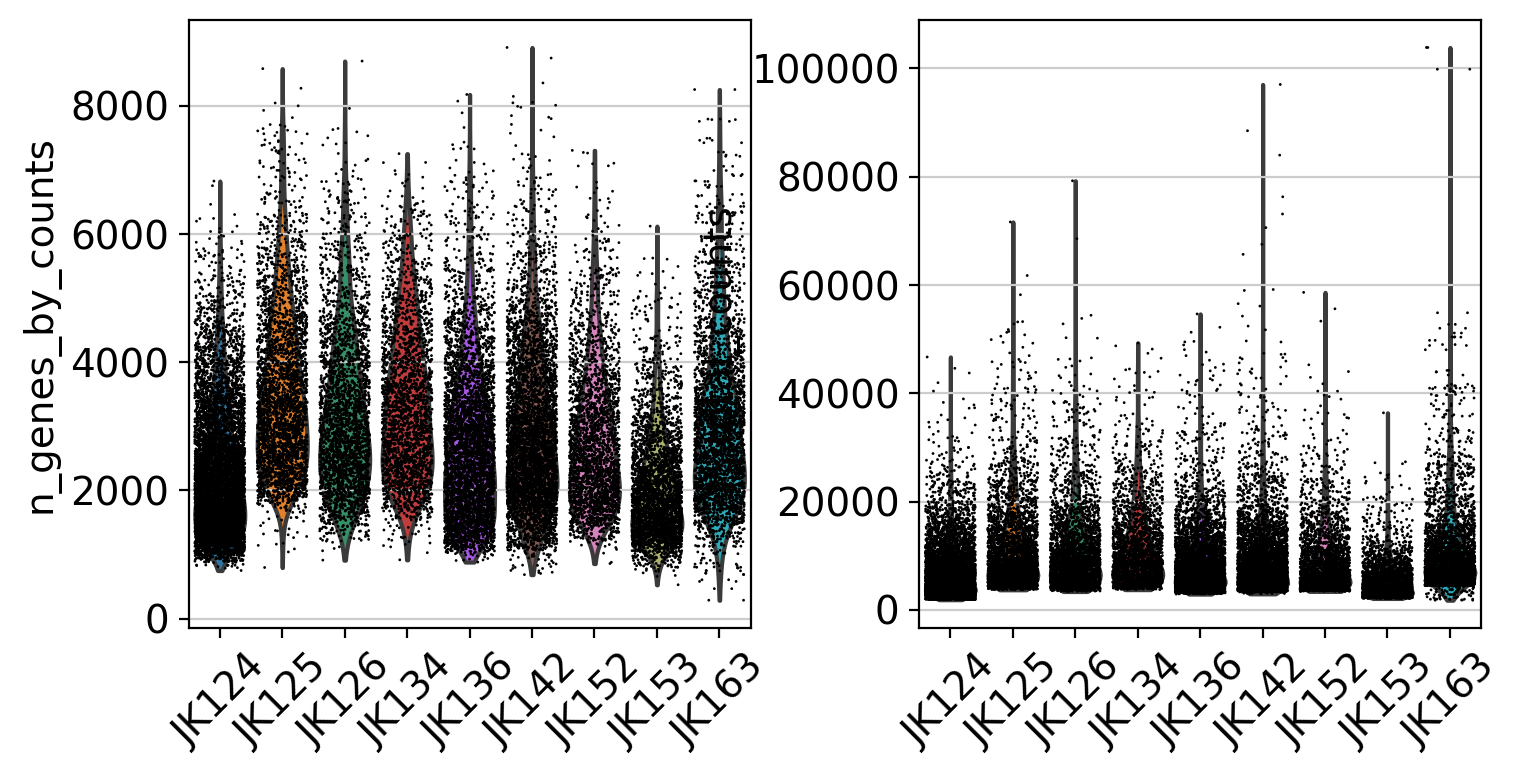

In [76]:
sc.set_figure_params(dpi=100)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

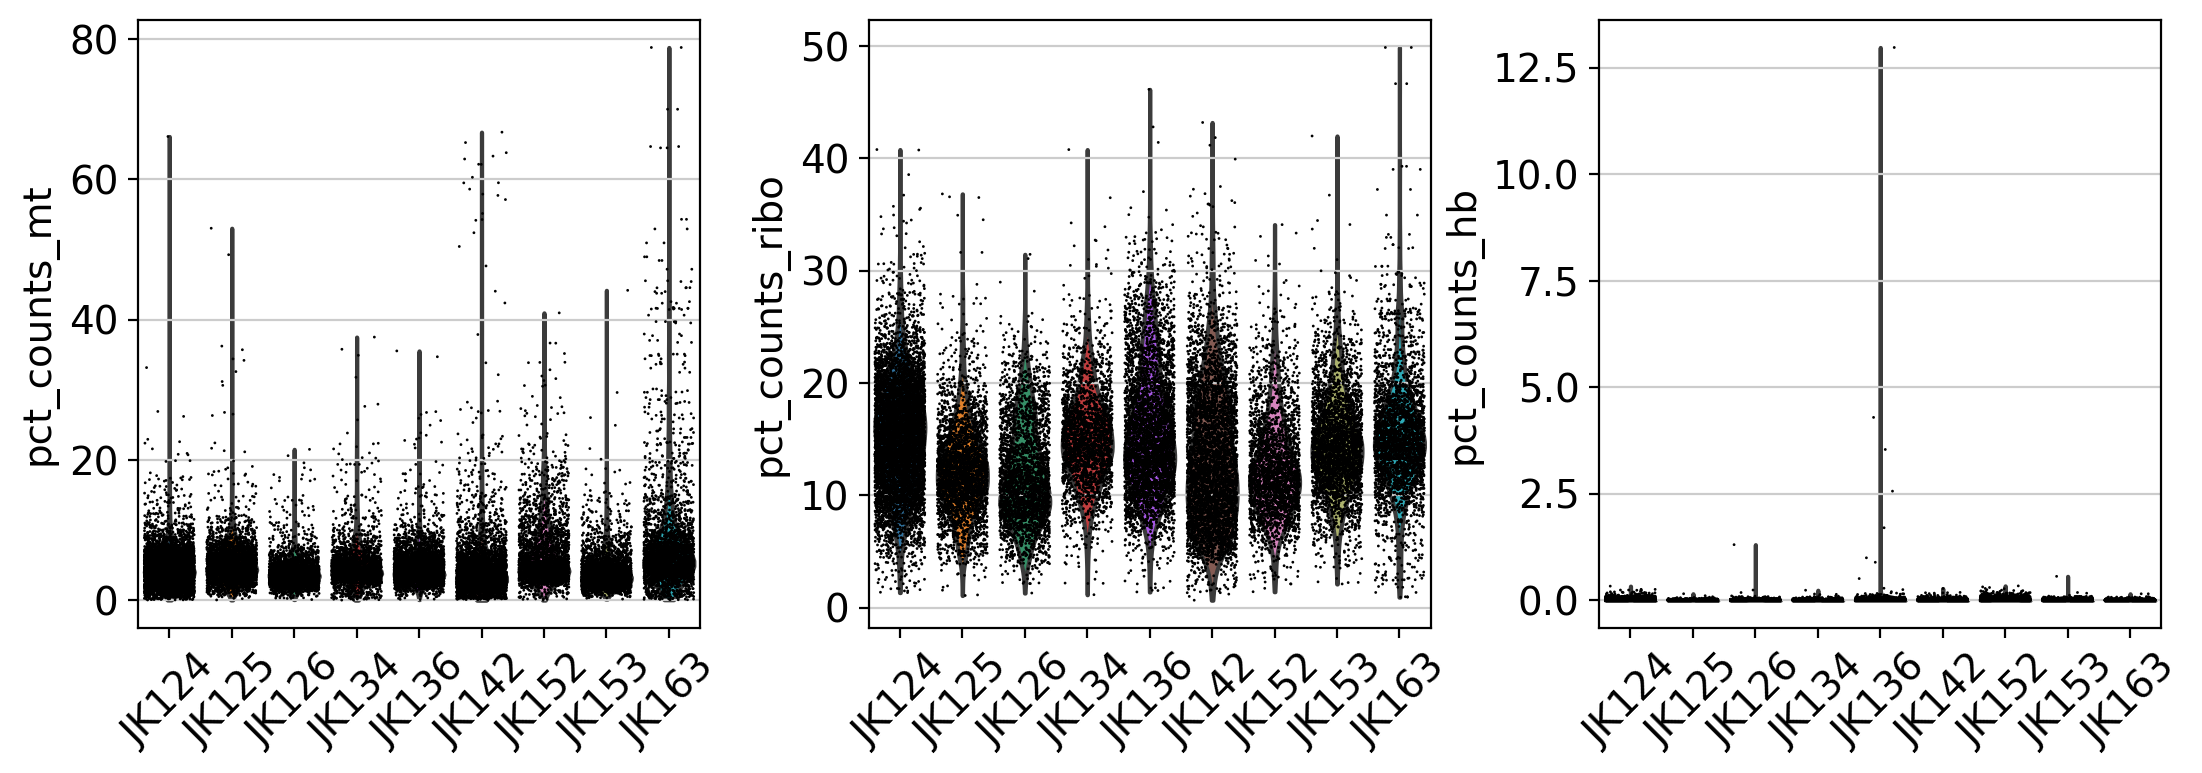

In [77]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

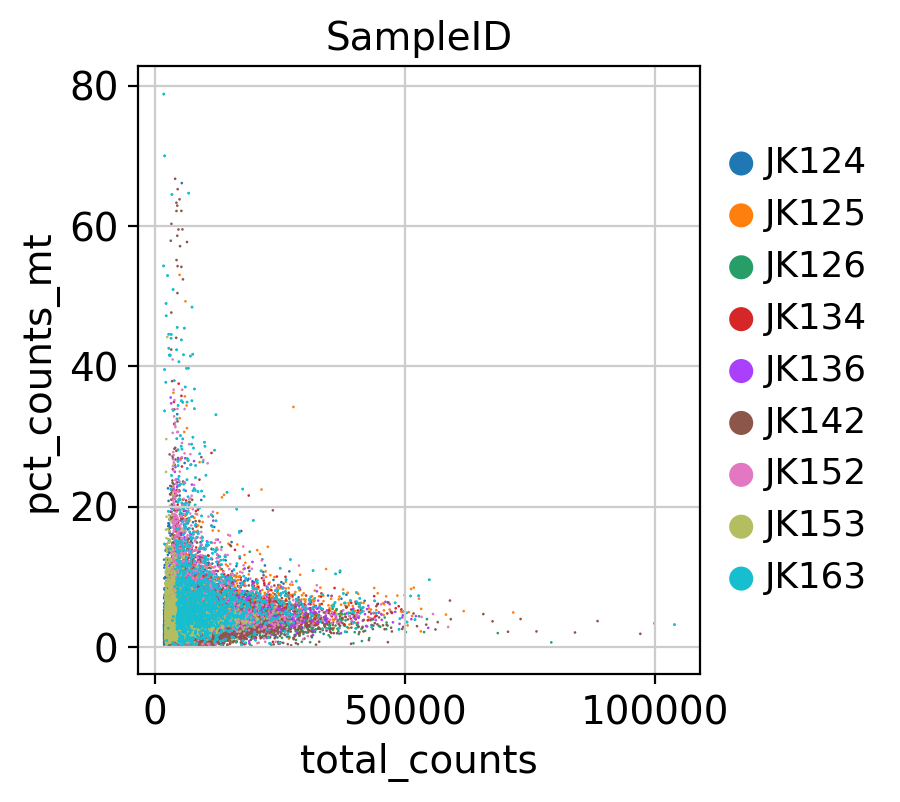

In [78]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="SampleID")

# Filtering

In [79]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

33257 24612


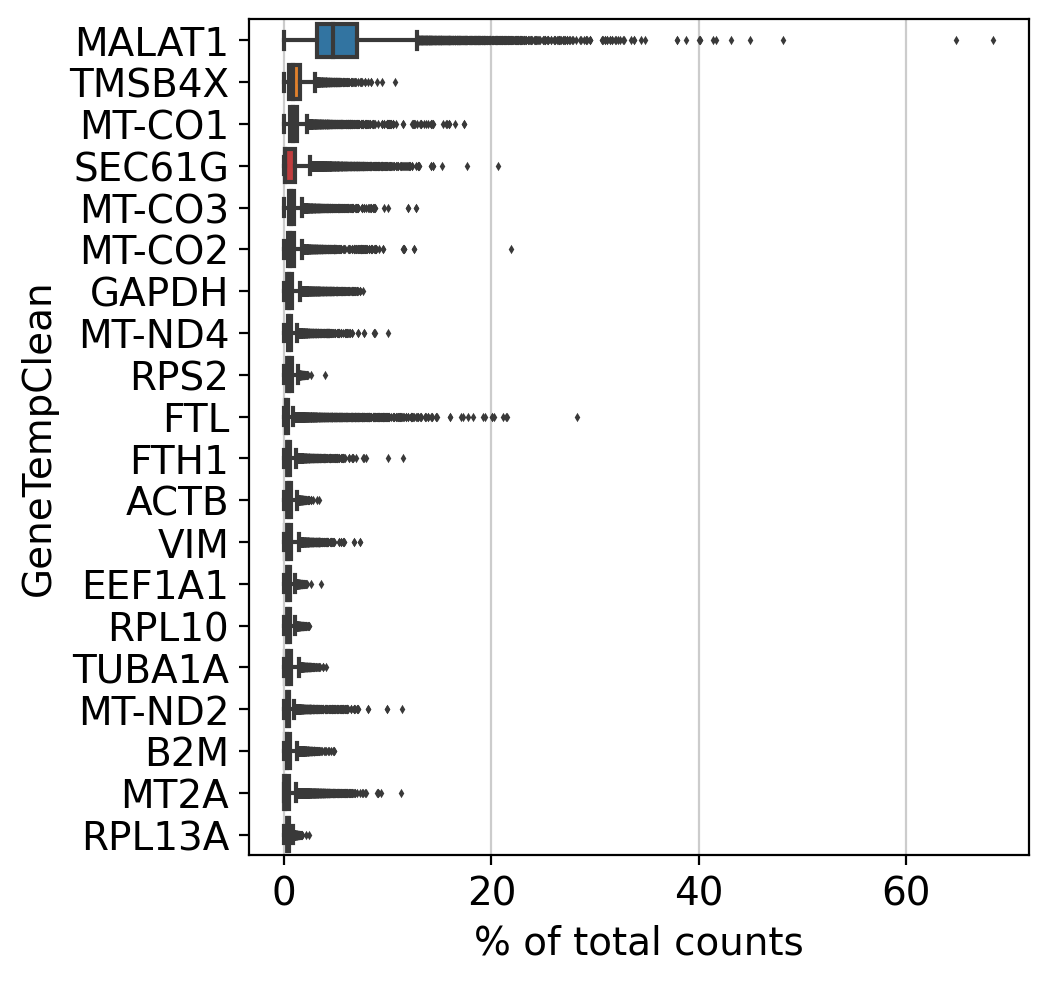

In [80]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Mito/Ribo filtering

In [81]:
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 2, :]
adata = adata[adata.obs['pct_counts_hb'] < 2, :]
print("Remaining cells %d"%adata.n_obs)

Remaining cells 32855


# Plot filtered QC

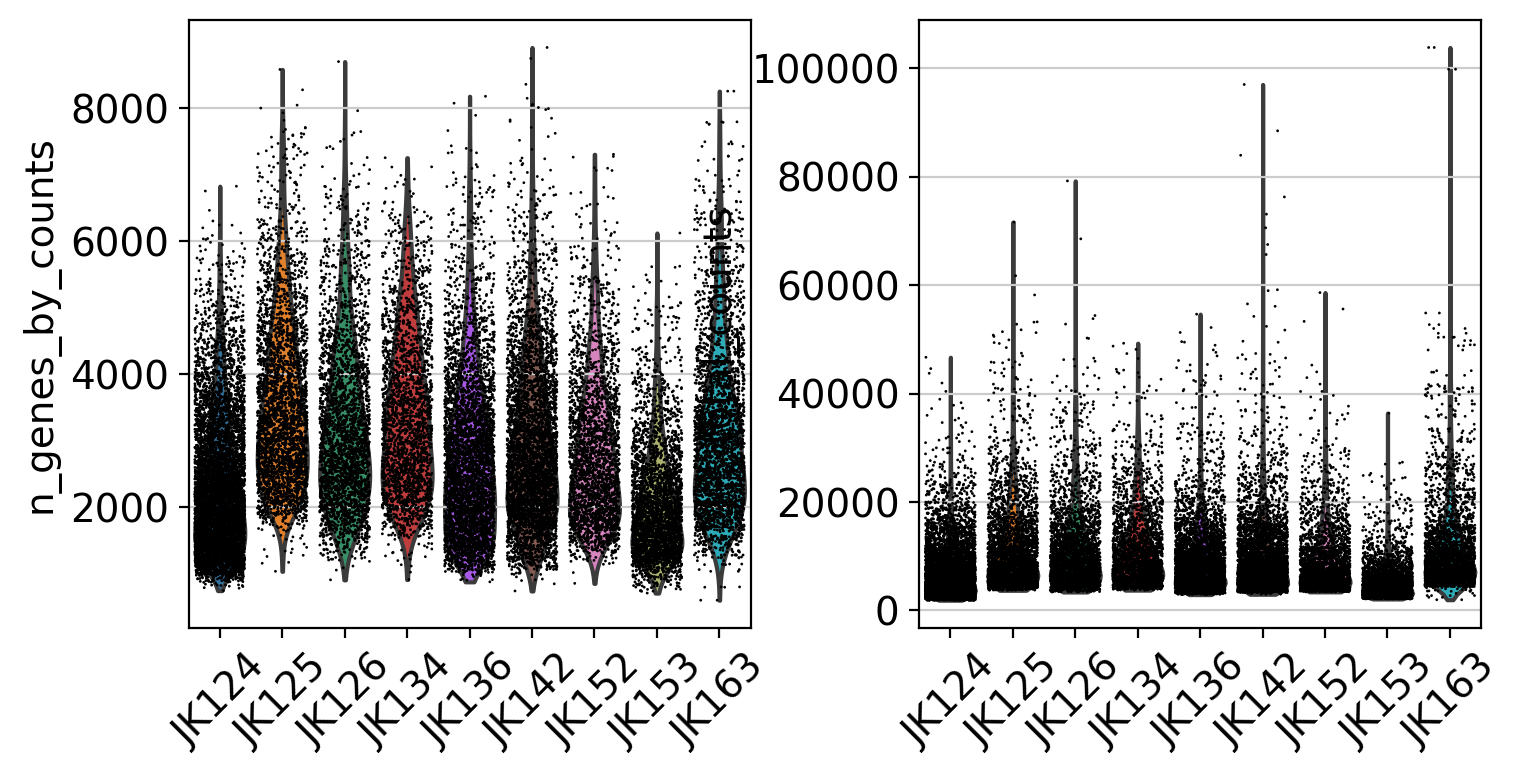

In [82]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

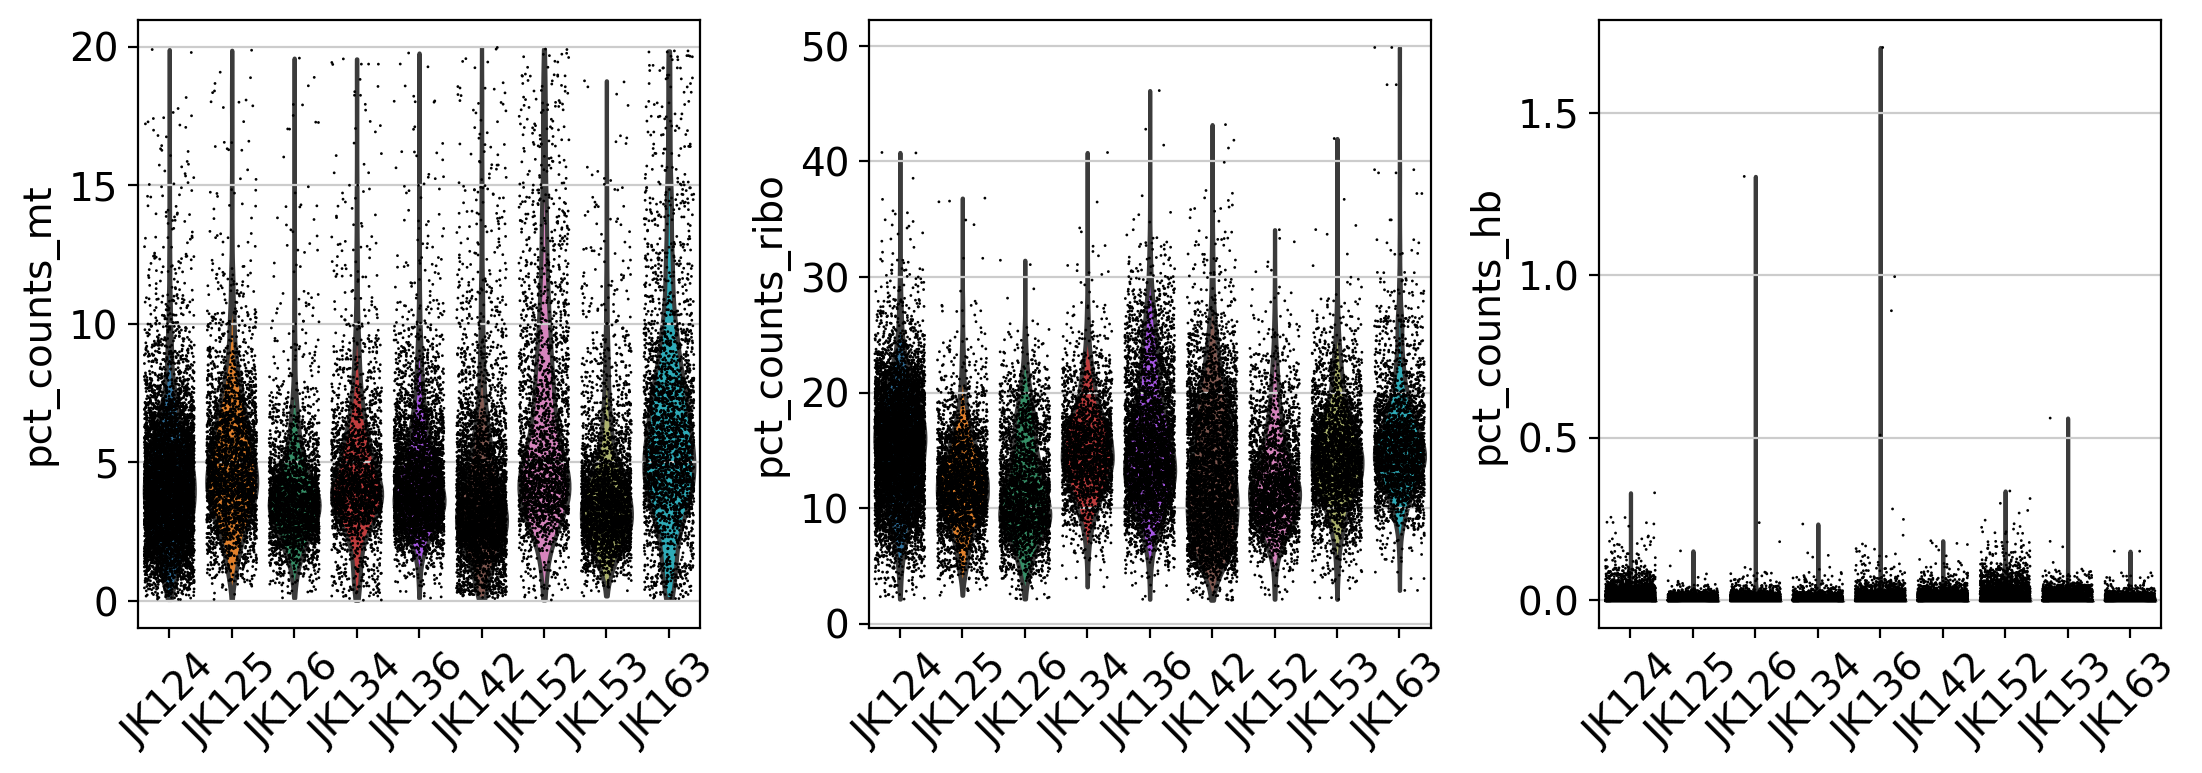

In [83]:
sc.pl.violin(adata, ['pct_counts_mt','pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby = 'SampleID', rotation= 45)

# Filter genes

In [84]:
mito_gene_names = sc.queries.mitochondrial_genes("hsapiens")

In [85]:
mito_gene_indicator = np.in1d(adata.var_names, mito_gene_names)

In [86]:
adata = adata[:, ~mito_gene_indicator]

In [87]:
print(adata.n_obs, adata.n_vars)
malat1 = adata.var_names.str.startswith('MALAT1')
# we need to redefine the mito_genes since they were first 
# calculated on the full object before removing low expressed genes.
ribo_genes = adata.var_names.str.startswith(("RPL","RPS"))
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(ribo_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:,keep]

print(adata.n_obs, adata.n_vars)

32855 24599
32855 24488


# Calculate cell-cycle scores

In [88]:
cell_cycle_genes = [x.strip() for x in open('/home/lugli/spuccio/Projects/SP035_TregIntegration/Analysis/regev_lab_cell_cycle_genes_homo.txt')]
print(len(cell_cycle_genes))
# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

90
89


In [89]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

... storing 'phase' as categorical


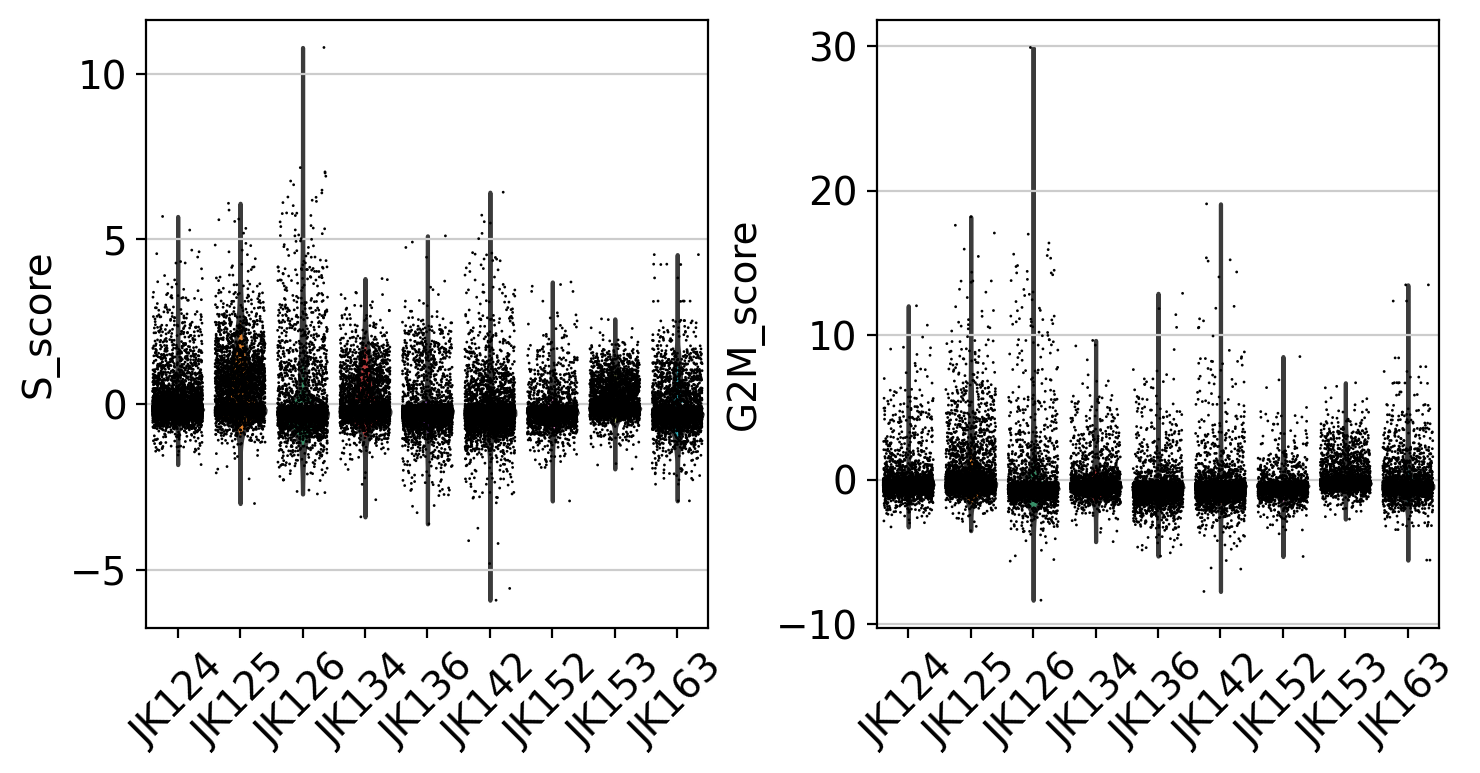

In [90]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'SampleID', rotation=45)

# Predict doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 21.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.3%
Elapsed time: 45.2 seconds


92

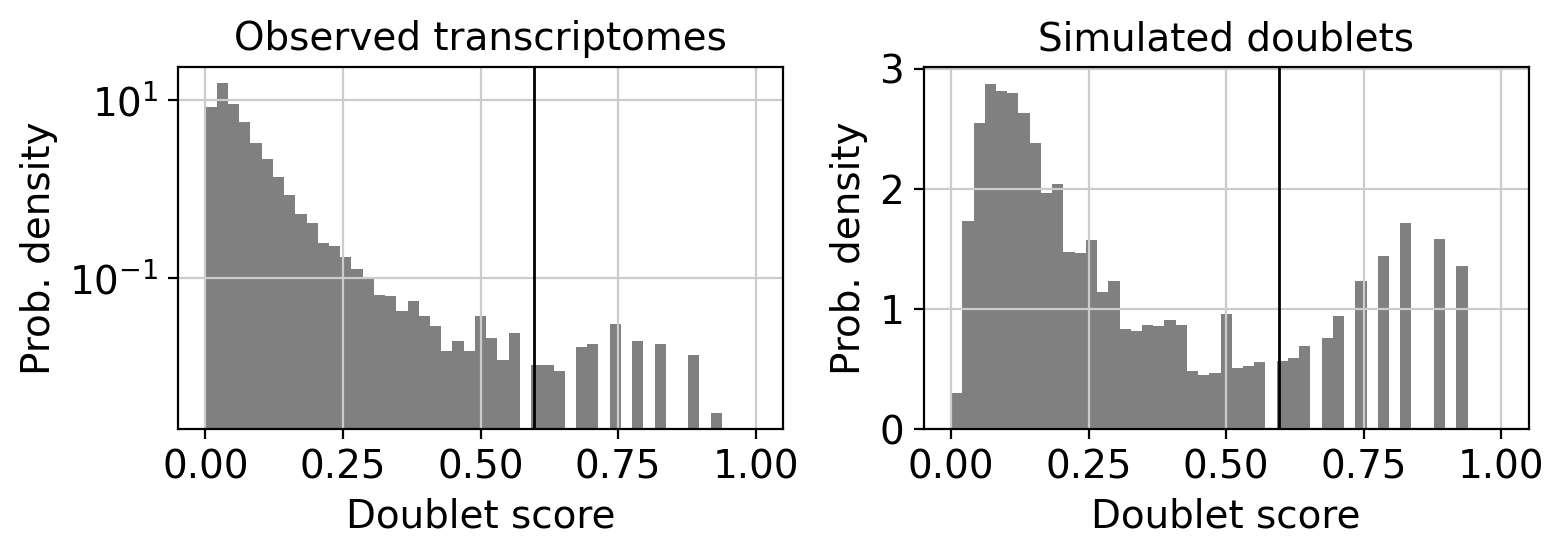

In [91]:
scrub = scr.Scrublet(adata.layers['raw'])
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [92]:
# add in column with singlet/doublet instead of True/False
adata.obs['doublet_info'] = adata.obs["predicted_doublets"].astype(str)

... storing 'doublet_info' as categorical


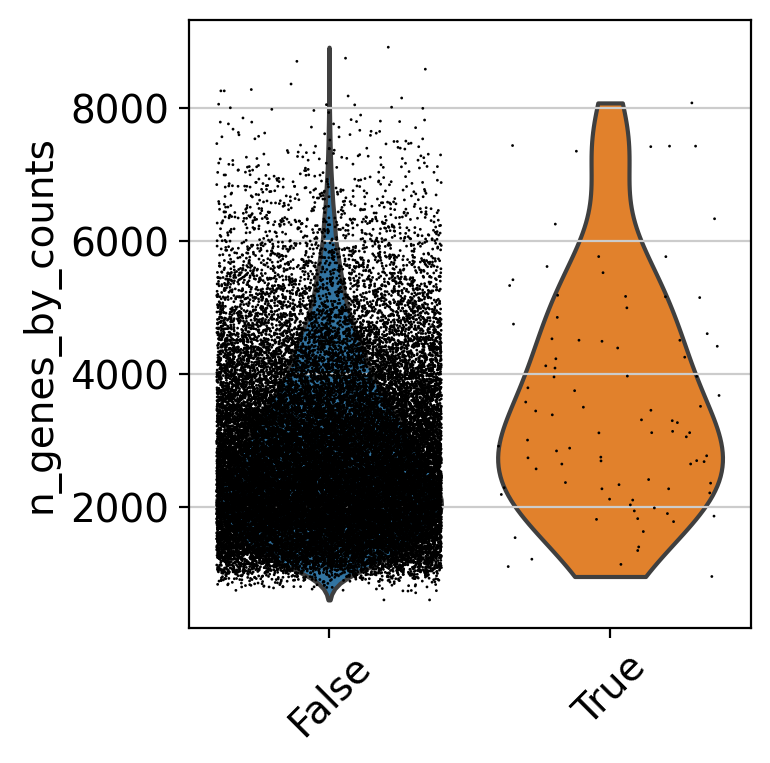

In [93]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4, groupby = 'doublet_info', rotation=45)

In [94]:
adata = adata[adata.obs['doublet_info'] == "False",:]

# Processing 

In [106]:
adata.X = adata.layers['raw']

In [107]:
#adata = adata[adata.obs.n_genes_by_counts < 3000, :]
# save normalized counts in raw slot.

adata.raw = adata
# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
adata.layers['cpm'] = adata.X
# logaritmize
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# Filter higly variable genes
#adata.raw = adata

# scale
#sc.pp.scale(adata)

# Celltypist classification

In [108]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

In [109]:
sc.pp.neighbors(adata,n_neighbors=10, n_pcs=40)

In [110]:
sce.pp.harmony_integrate(adata, ['SampleID'])

2022-06-14 17:27:23,664 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2022-06-14 17:27:30,321 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2022-06-14 17:27:37,027 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2022-06-14 17:27:43,718 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2022-06-14 17:27:50,373 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2022-06-14 17:27:57,029 - harmonypy - INFO - Converged after 5 iterations
Converged after 5 iterations


In [111]:
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca_harmony')

In [112]:
sc.tl.umap(adata)

In [113]:
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap']

In [114]:
adata

AnnData object with n_obs × n_vars = 32763 × 24488
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'pca', 'neighbors', 'umap', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony'
    varm: 'PCs'
    layers: 'raw', 'cpm', 'log1p'
    obsp: 'distances', 'connectivities'

In [115]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 13
📂 Storing models in /home/lugli/spuccio/.celltypist/data/models
💾 Downloading model [1/13]: Immune_All_Low.pkl
💾 Downloading model [2/13]: Immune_All_High.pkl
💾 Downloading model [3/13]: Immune_All_PIP.pkl
💾 Downloading model [4/13]: Immune_All_AddPIP.pkl
💾 Downloading model [5/13]: COVID19_Immune_Landscape.pkl
💾 Downloading model [6/13]: Cells_Fetal_Lung.pkl
💾 Downloading model [7/13]: Cells_Intestinal_Tract.pkl
💾 Downloading model [8/13]: Cells_Lung_Airway.pkl
💾 Downloading model [9/13]: Developing_Mouse_Brain.pkl
💾 Downloading model [10/13]: Healthy_COVID19_PBMC.pkl
💾 Downloading model [11/13]: Human_Lung_Atlas.pkl
💾 Downloading model [12/13]: Nuclei_Lung_Airway.pkl
💾 Downloading model [13/13]: Pan_Fetal_Human.pkl


In [116]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [117]:
predictionsHigh = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

🔬 Input data has 32763 cells and 24488 genes
🔗 Matching reference genes in the model
🧬 2654 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 15
🗳️ Majority voting the predictions
✅ Majority voting done!


In [118]:
adata.obs['CellCount']= adata.obs['CellCount'].astype(int)

In [119]:
adata.obs['Sample'].value_counts()

Patient99     6950
Patient104    4459
Patient103    4334
Patient106    3263
Patient100    3138
Patient108    2906
Patient101    2827
Patient105    2563
Patient102    2323
Name: Sample, dtype: int64

In [120]:
adata.obs

SampleID     GEO_RNA     Cohort          Type       Subtype  \
JK124_0-0       JK124  GSM5264672  GSE173280  PrimaryTumor  NotAvailable   
JK124_1-0       JK124  GSM5264672  GSE173280  PrimaryTumor  NotAvailable   
JK124_2-0       JK124  GSM5264672  GSE173280  PrimaryTumor  NotAvailable   
JK124_3-0       JK124  GSM5264672  GSE173280  PrimaryTumor  NotAvailable   
JK124_4-0       JK124  GSM5264672  GSE173280  PrimaryTumor  NotAvailable   
...               ...         ...        ...           ...           ...   
JK163_1542-9    JK163  GSM5264680  GSE173280  PrimaryTumor  NotAvailable   
JK163_1543-9    JK163  GSM5264680  GSE173280  PrimaryTumor  NotAvailable   
JK163_1544-9    JK163  GSM5264680  GSE173280  PrimaryTumor  NotAvailable   
JK163_1546-9    JK163  GSM5264680  GSE173280  PrimaryTumor  NotAvailable   
JK163_1547-9    JK163  GSM5264680  GSE173280  PrimaryTumor  NotAvailable   

                 Diagnosis         Grade        Location IDH1_Status  \
JK124_0-0     Glioblastoma  NotAvailable  Right_Temporal          WT   
JK124_1-0     Glioblastoma  NotAvailable  Right_Temporal          WT   
JK124_2-0     Glioblastoma  NotAvailable  Right_Temporal          WT   
JK124_3-0     Glioblastoma  NotAvailable  Right_Temporal          WT   
JK124_4-0     Glioblastoma  NotAvailable  Right_Temporal          WT   
...                    ...           ...             ...         ...   
JK163_1542-9  Glioblastoma  NotAvailable   Right_Frontal          WT   
JK163_1543-9  Glioblastoma  NotAvailable   Right_Frontal          WT   
JK163_1544-9  Glioblastoma  NotAvailable   Right_Frontal          WT   
JK163_1546-9  Glioblastoma  NotAvailable   Right_Frontal          WT   
JK163_1547-9  Glioblastoma  NotAvailable   Right_Frontal          WT   

               EGFR_Status  ... pct_counts_hb  percent_mt2 n_counts n_genes  \
JK124_0-0     NotAvailable  ...      0.000000     0.019361   3033.0    1803   
JK124_1-0     NotAvailable  ...      0.000000     0.007103   3838.0    1887   
JK124_2-0     NotAvailable  ...      0.000000     0.021688   2264.0    1455   
JK124_3-0     NotAvailable  ...      0.018420     0.043654  16718.0    4490   
JK124_4-0     NotAvailable  ...      0.012634     0.058244   5923.0    2658   
...                    ...  ...           ...          ...      ...     ...   
JK163_1542-9  NotAvailable  ...      0.000000     0.046932   6292.0    2361   
JK163_1543-9  NotAvailable  ...      0.000000     0.086003   2349.0    1567   
JK163_1544-9  NotAvailable  ...      0.000000     0.092393   6746.0    3028   
JK163_1546-9  NotAvailable  ...      0.004709     0.108254  13888.0    4297   
JK163_1547-9  NotAvailable  ...      0.000000     0.075621   6398.0    2742   

               S_score G2M_score phase doublet_scores  predicted_doublets  \
JK124_0-0    -0.241624 -0.230709    G1       0.027171               False   
JK124_1-0    -0.182499 -0.360803    G1       0.034682               False   
JK124_2-0    -0.070211 -0.176029    G1       0.040082               False   
JK124_3-0     3.365392  7.891480   G2M       0.084896               False   
JK124_4-0    -0.328538 -0.514998    G1       0.036239               False   
...                ...       ...   ...            ...                 ...   
JK163_1542-9 -0.748029 -0.571105    G1       0.025065               False   
JK163_1543-9 -0.131553 -0.147651    G1       0.073770               False   
JK163_1544-9  0.178557 -0.597344     S       0.074805               False   
JK163_1546-9 -0.594501 -1.142663    G1       0.037306               False   
JK163_1547-9 -0.220930 -0.379851    G1       0.046790               False   

              doublet_info  
JK124_0-0            False  
JK124_1-0            False  
JK124_2-0            False  
JK124_3-0            False  
JK124_4-0            False  
...                    ...  
JK163_1542-9         False  
JK163_1543-9         False  
JK163_1544-9         False  
JK163_1546-9         False  
JK163_1547-9         False  

[32763 rows 

In [121]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_P_GSE173278PMID35303420.h5ad")

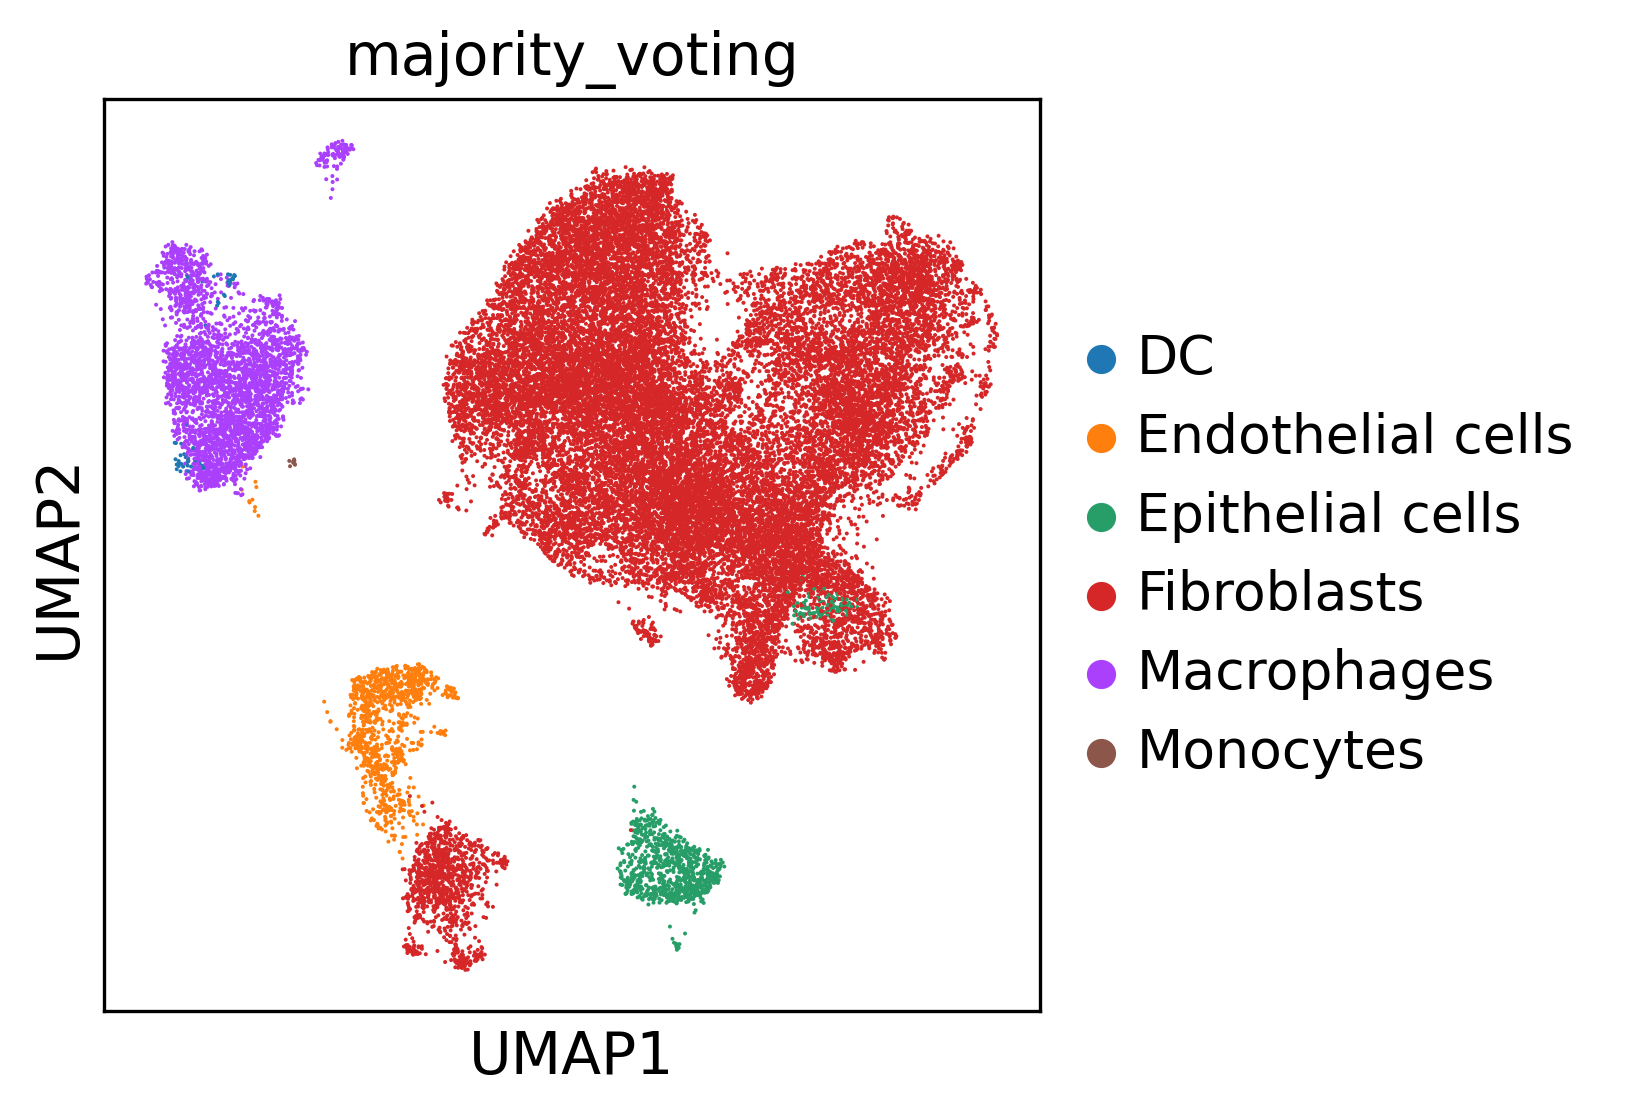

In [122]:
sc.set_figure_params(dpi=150)
sc.pl.umap(predictionsHigh.to_adata(), color='majority_voting')

# PanglaoDB classification

In [123]:
adata = adata[:, adata.var.highly_variable]

In [124]:
markers = dc.get_resource('PanglaoDB')
markers

label genesymbol canonical_marker         cell_type germ_layer human  \
0          CTRB1            False       Enterocytes   Endoderm  True   
1          CTRB1             True      Acinar cells   Endoderm  True   
2           KLK1             True      Acinar cells   Endoderm  True   
3           KLK1            False      Goblet cells   Endoderm  True   
4           KLK1            False  Epithelial cells   Mesoderm  True   
...          ...              ...               ...        ...   ...   
8472     SLC14A1             True  Urothelial cells   Mesoderm  True   
8473       UPK3A             True  Urothelial cells   Mesoderm  True   
8474       UPK1A             True  Urothelial cells   Mesoderm  True   
8475        UPK2             True  Urothelial cells   Mesoderm  True   
8476       UPK3B             True  Urothelial cells   Mesoderm  True   

label human_sensitivity human_specificity mouse mouse_sensitivity  \
0                   0.0        0.00439422  True        0.00331126   
1                   1.0       0.000628931  True          0.957143   
2              0.833333        0.00503145  True          0.314286   
3              0.588235        0.00503937  True          0.903226   
4                   0.0        0.00823306  True          0.225806   
...                 ...               ...   ...               ...   
8472                0.0         0.0181704  True               0.0   
8473                0.0               0.0  True               0.0   
8474                0.0               0.0  True               0.0   
8475                0.0               0.0  True               0.0   
8476                0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
0             0.0204803        9606         GI tract           0.017  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
3             0.0124084        9606         GI tract           0.013  
4             0.0137585        9606       Epithelium           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[8477 rows x 13 columns]

In [125]:
markers['organ'].value_counts()

Immune system         1775
Brain                 1589
GI tract               540
Kidney                 450
Reproductive           429
Connective tissue      413
Vasculature            372
Pancreas               365
Liver                  310
Epithelium             258
Blood                  247
Bone                   215
Lungs                  210
Skin                   172
Skeletal muscle        168
Olfactory system       136
Heart                  131
Smooth muscle          130
Eye                    122
Mammary gland           94
Zygote                  85
Embryo                  56
Placenta                28
Thymus                  27
Adrenal glands          25
Oral cavity             18
Thyroid                 14
Urinary bladder         11
Parathyroid glands      10
Name: organ, dtype: int64

In [126]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

label genesymbol canonical_marker                     cell_type germ_layer  \
1          CTRB1             True                  Acinar cells   Endoderm   
2           KLK1             True                  Acinar cells   Endoderm   
5           KLK1             True               Principal cells   Mesoderm   
7           KLK1             True  Plasmacytoid dendritic cells   Mesoderm   
8           KLK1             True             Endothelial cells   Mesoderm   
...          ...              ...                           ...        ...   
8472     SLC14A1             True              Urothelial cells   Mesoderm   
8473       UPK3A             True              Urothelial cells   Mesoderm   
8474       UPK1A             True              Urothelial cells   Mesoderm   
8475        UPK2             True              Urothelial cells   Mesoderm   
8476       UPK3B             True              Urothelial cells   Mesoderm   

label human human_sensitivity human_specificity mouse mouse_sensitivity  \
1      True               1.0       0.000628931  True          0.957143   
2      True          0.833333        0.00503145  True          0.314286   
5      True               0.0        0.00814536  True          0.285714   
7      True               0.0        0.00820189  True               1.0   
8      True               0.0        0.00841969  True               0.0   
...     ...               ...               ...   ...               ...   
8472   True               0.0         0.0181704  True               0.0   
8473   True               0.0               0.0  True               0.0   
8474   True               0.0               0.0  True               0.0   
8475   True               0.0               0.0  True               0.0   
8476   True               0.0               0.0  True               0.0   

label mouse_specificity ncbi_tax_id            organ ubiquitiousness  
1             0.0159201        9606         Pancreas           0.017  
2             0.0128263        9606         Pancreas           0.013  
5             0.0140583        9606           Kidney           0.013  
7             0.0129136        9606    Immune system           0.013  
8             0.0149153        9606      Vasculature           0.013  
...                 ...         ...              ...             ...  
8472                0.0        9606  Urinary bladder           0.008  
8473                0.0        9606  Urinary bladder             0.0  
8474                0.0        9606  Urinary bladder             0.0  
8475                0.0        9606  Urinary bladder             0.0  
8476                0.0        9606  Urinary bladder             0.0  

[5180 rows x 13 columns]

In [127]:
# Run leiden clustering algorithm
sc.tl.leiden(adata)

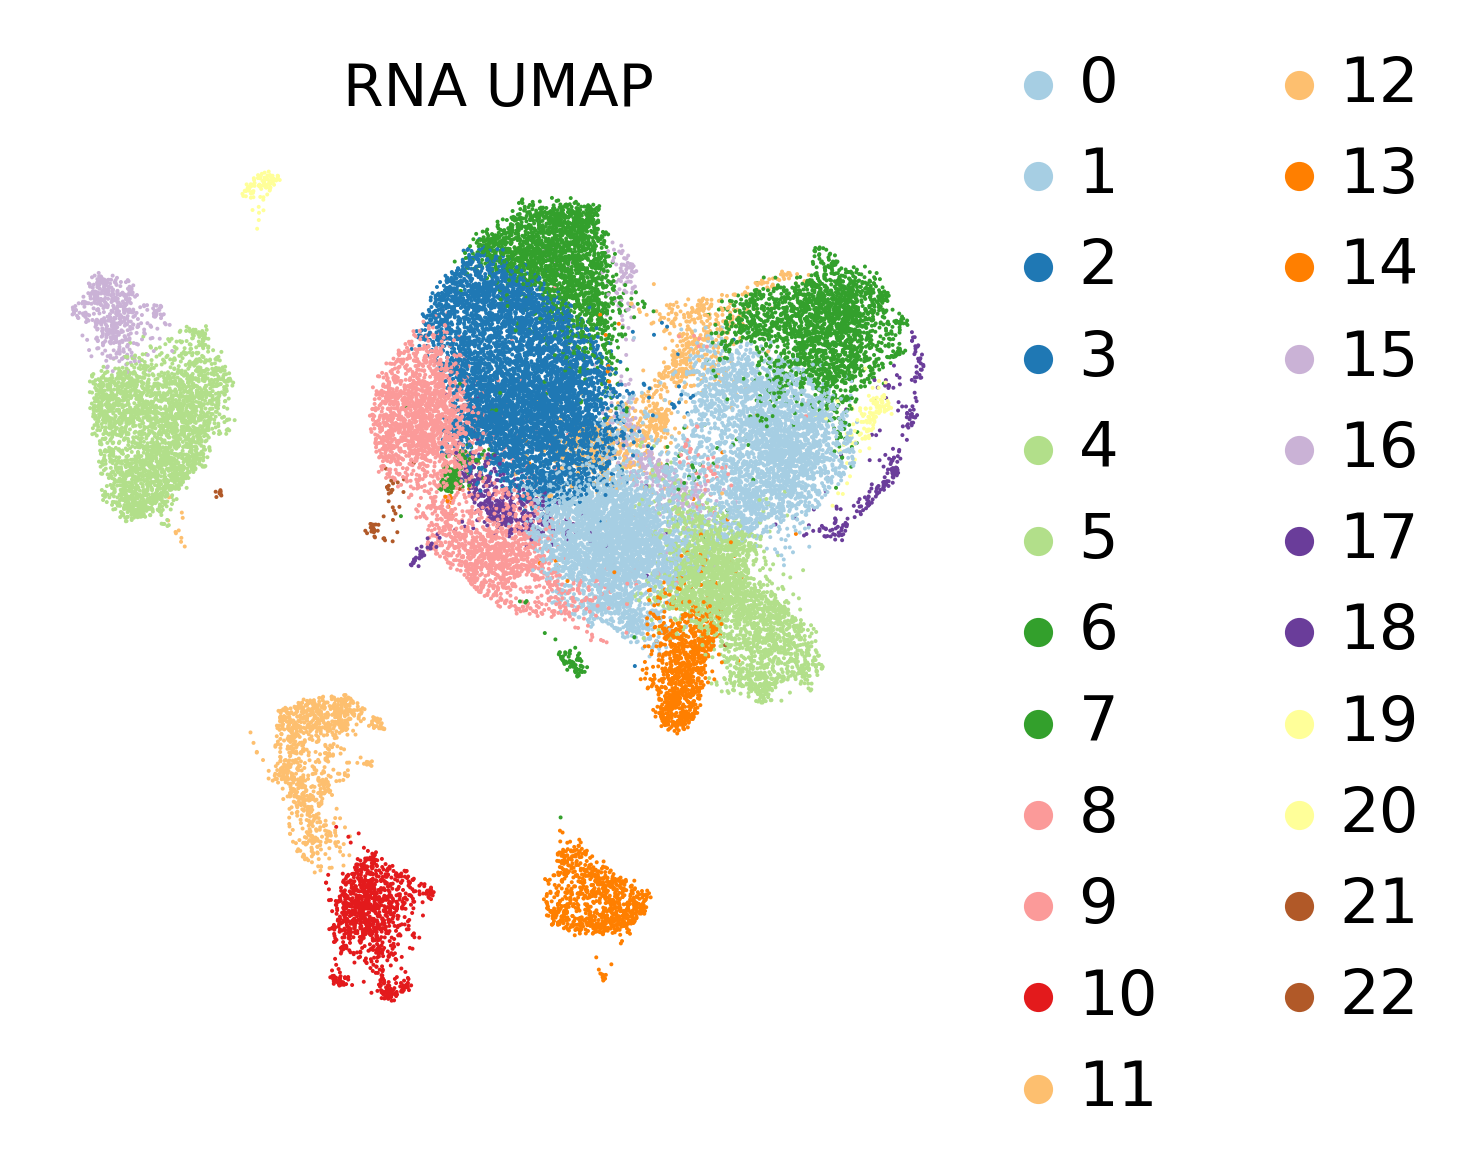

In [128]:
# Visualize
sc.pl.umap(adata, color='leiden', title='RNA UMAP',palette='Paired',
           frameon=False, legend_fontweight='normal', legend_fontsize=15)

In [129]:
dc.run_ora(mat=adata, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True,use_raw=False)

Running ora on mat with 32763 samples and 2470 targets for 111 sources.


100%|██████████| 32763/32763 [00:11<00:00, 2893.63it/s]


In [130]:
adata.obsm['ora_estimate']

source        Acinar cells  Adipocytes  Alpha cells  Alveolar macrophages  \
JK124_0-0        -0.000000    1.634938    -0.000000                  -0.0   
JK124_1-0        -0.000000    2.776025    -0.000000                  -0.0   
JK124_2-0         2.982160    2.776025    -0.000000                  -0.0   
JK124_3-0        -0.000000    1.634938     1.143067                  -0.0   
JK124_4-0        -0.000000    2.776025     2.616829                  -0.0   
...                    ...         ...          ...                   ...   
JK163_1542-9      2.982160    2.776025    -0.000000                  -0.0   
JK163_1543-9      1.313853    0.676426     1.143067                  -0.0   
JK163_1544-9      1.313853    4.054244     1.143067                  -0.0   
JK163_1546-9      1.313853    5.443766     1.143067                  -0.0   
JK163_1547-9      1.313853    5.443766     1.143067                  -0.0   

source        Astrocytes   B cells  B cells memory  B cells naive  Basophils  \
JK124_0-0      -0.000000 -0.000000       -0.000000      -0.000000  -0.000000   
JK124_1-0       0.857824 -0.000000       -0.000000      -0.000000  -0.000000   
JK124_2-0       3.368500 -0.000000       -0.000000      -0.000000   1.917398   
JK124_3-0       2.016545 -0.000000       -0.000000      -0.000000  -0.000000   
JK124_4-0       4.866885 -0.000000       -0.000000      -0.000000  -0.000000   
...                  ...       ...             ...            ...        ...   
JK163_1542-9    4.866885  2.480854       -0.000000       0.974893   0.810588   
JK163_1543-9    3.368500 -0.000000       -0.000000      -0.000000  -0.000000   
JK163_1544-9    4.866885 -0.000000        0.931764      -0.000000  -0.000000   
JK163_1546-9    4.866885  1.078765        0.931764      -0.000000   1.917398   
JK163_1547-9    2.016545 -0.000000        2.171687      -0.000000   0.810588   

source        Bergmann glia  ...  Sertoli cells  Smooth muscle cells  \
JK124_0-0          0.952727  ...      -0.000000            -0.000000   
JK124_1-0          2.215689  ...      -0.000000            -0.000000   
JK124_2-0          2.215689  ...      -0.000000             0.638105   
JK124_3-0          3.678558  ...      -0.000000            -0.000000   
JK124_4-0         10.852094  ...      -0.000000            -0.000000   
...                     ...  ...            ...                  ...   
JK163_1542-9       2.215689  ...       2.420465             0.638105   
JK163_1543-9       5.294449  ...      -0.000000             0.638105   
JK163_1544-9       7.037985  ...      -0.000000            -0.000000   
JK163_1546-9      10.852094  ...      -0.000000             0.638105   
JK163_1547-9       5.294449  ...      -0.000000            -0.000000   

source        Stromal cells   T cells  T helper cells  T regulatory cells  \
JK124_0-0              -0.0  0.911887            -0.0                -0.0   
JK124_1-0              -0.0  0.911887            -0.0                -0.0   
JK124_2-0              -0.0  0.911887            -0.0                -0.0   
JK124_3-0              -0.0  0.911887            -0.0                -0.0   
JK124_4-0              -0.0 -0.000000            -0.0                -0.0   
...                     ...       ...             ...                 ...   
JK163_1542-9           -0.0  0.911887            -0.0                -0.0   
JK163_1543-9           -0.0  0.911887            -0.0                -0.0   
JK163_1544-9           -0.0  0.911887            -0.0                -0.0   
JK163_1546-9           -0.0  0.911887            -0.0                -0.0   
JK163_1547-9           -0.0  0.911887            -0.0                -0.0   

source        Tanycytes  Taste receptor cells  Thymocytes  Tuft cells  
JK124_0-0      4.196702             -0.000000        -0.0    1.143067  
JK124_1-0      2.546040              1.733161        -0.0    2.616829  
JK124_2-0      1.109628             -0.000000        -0.0   -0.000000  
JK124_3-0      2.546040             

In [131]:
adata.obsm['ora_estimate'].columns

Index(['Acinar cells', 'Adipocytes', 'Alpha cells', 'Alveolar macrophages',
       'Astrocytes', 'B cells', 'B cells memory', 'B cells naive', 'Basophils',
       'Bergmann glia',
       ...
       'Sertoli cells', 'Smooth muscle cells', 'Stromal cells', 'T cells',
       'T helper cells', 'T regulatory cells', 'Tanycytes',
       'Taste receptor cells', 'Thymocytes', 'Tuft cells'],
      dtype='object', name='source', length=111)

In [132]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')
acts

AnnData object with n_obs × n_vars = 32763 × 111
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden'
    uns: 'SampleID_colors', 'doublet_info_colors', 'pca', 'neighbors', 'umap', 'log1p', 'hvg', 'leiden', 'majority_voting_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umap_harmony', 'ora_estimate', 'ora_pvals'

In [133]:
mean_enr = dc.summarize_acts(acts, groupby='leiden', min_std=1)
mean_enr

Adipocytes  Astrocytes   B cells  B cells naive  Bergmann glia  \
0     3.767190    6.004189  0.204609       0.071321       7.935423   
1     2.411088    3.159856  0.502710       0.035211       5.083133   
10    0.899615    0.645380  0.323812       0.266147       2.100037   
11    2.684392    4.236356  0.269103       0.030699       5.292825   
12    0.649118    1.269876  0.520652       0.296682       3.527288   
13    1.992969    2.610528  0.684524       0.053404       2.998007   
14    0.957258    2.939267  0.212874       0.051921       2.060793   
15    1.534302    0.773455  3.014158       2.191964       0.442153   
16    3.580378    5.473019  0.093230       0.033085       7.287527   
17    4.240015    6.928571  1.734416       0.741027       8.877523   
18    2.999506    3.141637  0.029288       0.000000       5.612042   
19    0.993624    3.532172  0.249631       0.024171       4.069804   
2     3.063661    4.547423  0.585536       0.112877       5.951745   
20    2.090425    0.560904  4.382979       4.142659       0.536229   
21    3.845947    4.799155  2.800814       1.890121       6.357506   
22    1.480917    1.871705  5.685025       2.543329       0.000000   
3     2.870899    4.078213  0.343068       0.094344       4.631688   
4     2.164973    0.780282  3.502733       3.226659       0.590518   
5     2.086393    3.510642  0.477204       0.049731       4.574293   
6     2.081923    2.263233  0.392541       0.084686       2.621041   
7     1.815855    2.856526  0.474449       0.053663       4.370787   
8     2.945378    6.070507  0.678152       0.297409       7.115335   
9     3.516834    8.912688  0.499318       0.197764       9.205616   

    Dendritic cells  Embryonic stem cells  Endothelial cells  Ependymal cells  \
0          4.159811              2.361658           5.173547         3.237710   
1          2.892470              1.913115           3.422980         2.259620   
10         2.859884              4.458167          10.048315         0.708513   
11         3.175973              1.959709           3.414408         2.829279   
12         3.128313              4.887538          33.188015         0.962075   
13         2.332124              2.068467           1.906168         1.348208   
14         3.185371              2.798381           5.151992         1.782339   
15        19.451405              0.629479           1.983358         0.445224   
16         3.663263              1.989388           4.376594         2.394990   
17         8.332689              1.985805           5.836541         3.698343   
18         3.189120              0.872048           2.549342         1.589115   
19         2.124516              1.754858           1.653925         2.568698   
2          4.579485              2.449105           6.529826         2.659377   
20        33.073936              1.289260           1.881080         0.236532   
21        15.822772              1.555068           5.477196         2.409955   
22        31.168537              0.656326           1.451467         0.000000   
3          4.036079              2.299468           6.040889         2.310630   
4         26.166378              0.992103           2.190485         0.461426   
5          2.713990              2.341621           3.133559         2.513321   
6          2.971681              2.204347           4.566541         1.285223   
7          3.139977              2.092520           3.542088         2.040318   
8          4.928177              2.405998           7.833333         3.873222   
9          4.610989              2.552514           6.652954         4.774806   

    Fibroblasts  ...  Neutrophils  Oligodendrocyte progenitor cells  \
0      3.322289  ...     0.108181                          4.022415   
1      2.296649  ...     0.165116                          3.922551   
10    18.178413  ...     0.339325                          0.336944   
11     2.260038  ...     0.221461                          1.946962   
12     8.721474  ...   

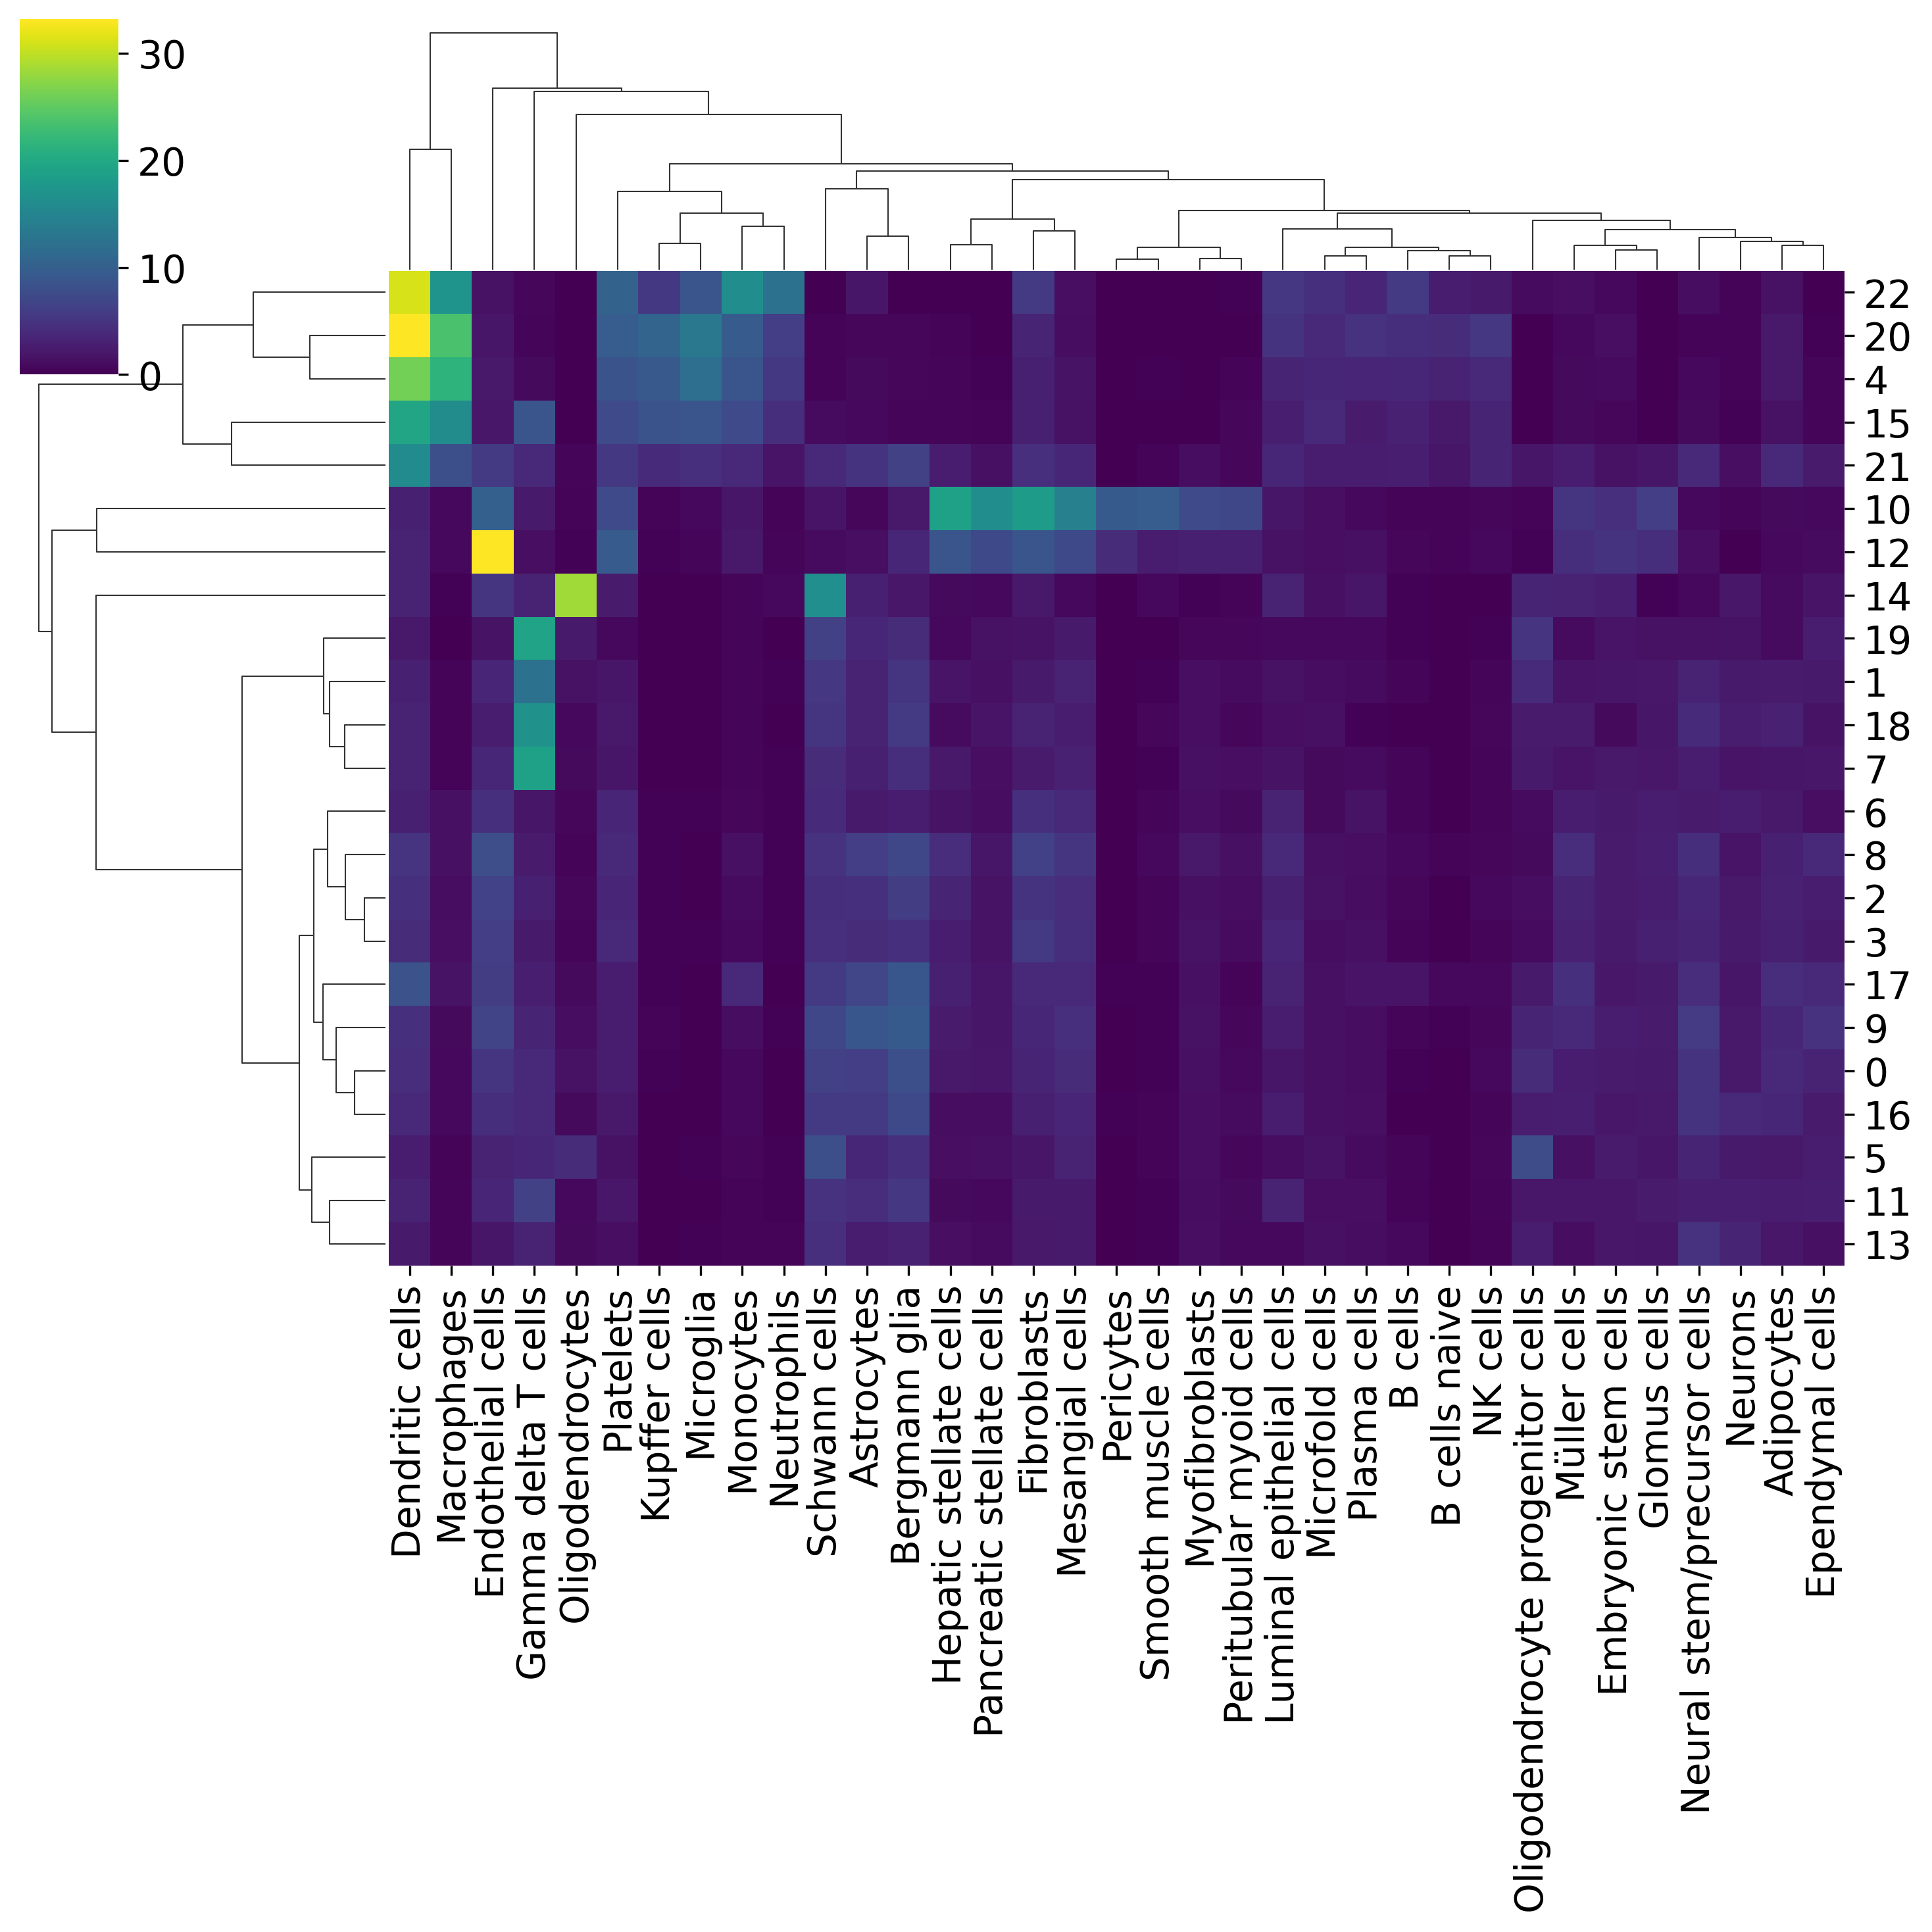

In [134]:
sns.clustermap(mean_enr, xticklabels=mean_enr.columns, cmap='viridis')
plt.show()

In [135]:
annotation_dict = dc.assign_groups(mean_enr)
annotation_dict

{'0': 'Bergmann glia',
 '1': 'Gamma delta T cells',
 '10': 'Hepatic stellate cells',
 '11': 'Gamma delta T cells',
 '12': 'Endothelial cells',
 '13': 'Neural stem/precursor cells',
 '14': 'Oligodendrocytes',
 '15': 'Dendritic cells',
 '16': 'Bergmann glia',
 '17': 'Bergmann glia',
 '18': 'Gamma delta T cells',
 '19': 'Gamma delta T cells',
 '2': 'Endothelial cells',
 '20': 'Dendritic cells',
 '21': 'Dendritic cells',
 '22': 'Dendritic cells',
 '3': 'Endothelial cells',
 '4': 'Dendritic cells',
 '5': 'Schwann cells',
 '6': 'Fibroblasts',
 '7': 'Gamma delta T cells',
 '8': 'Endothelial cells',
 '9': 'Bergmann glia'}

... storing 'cell_type' as categorical


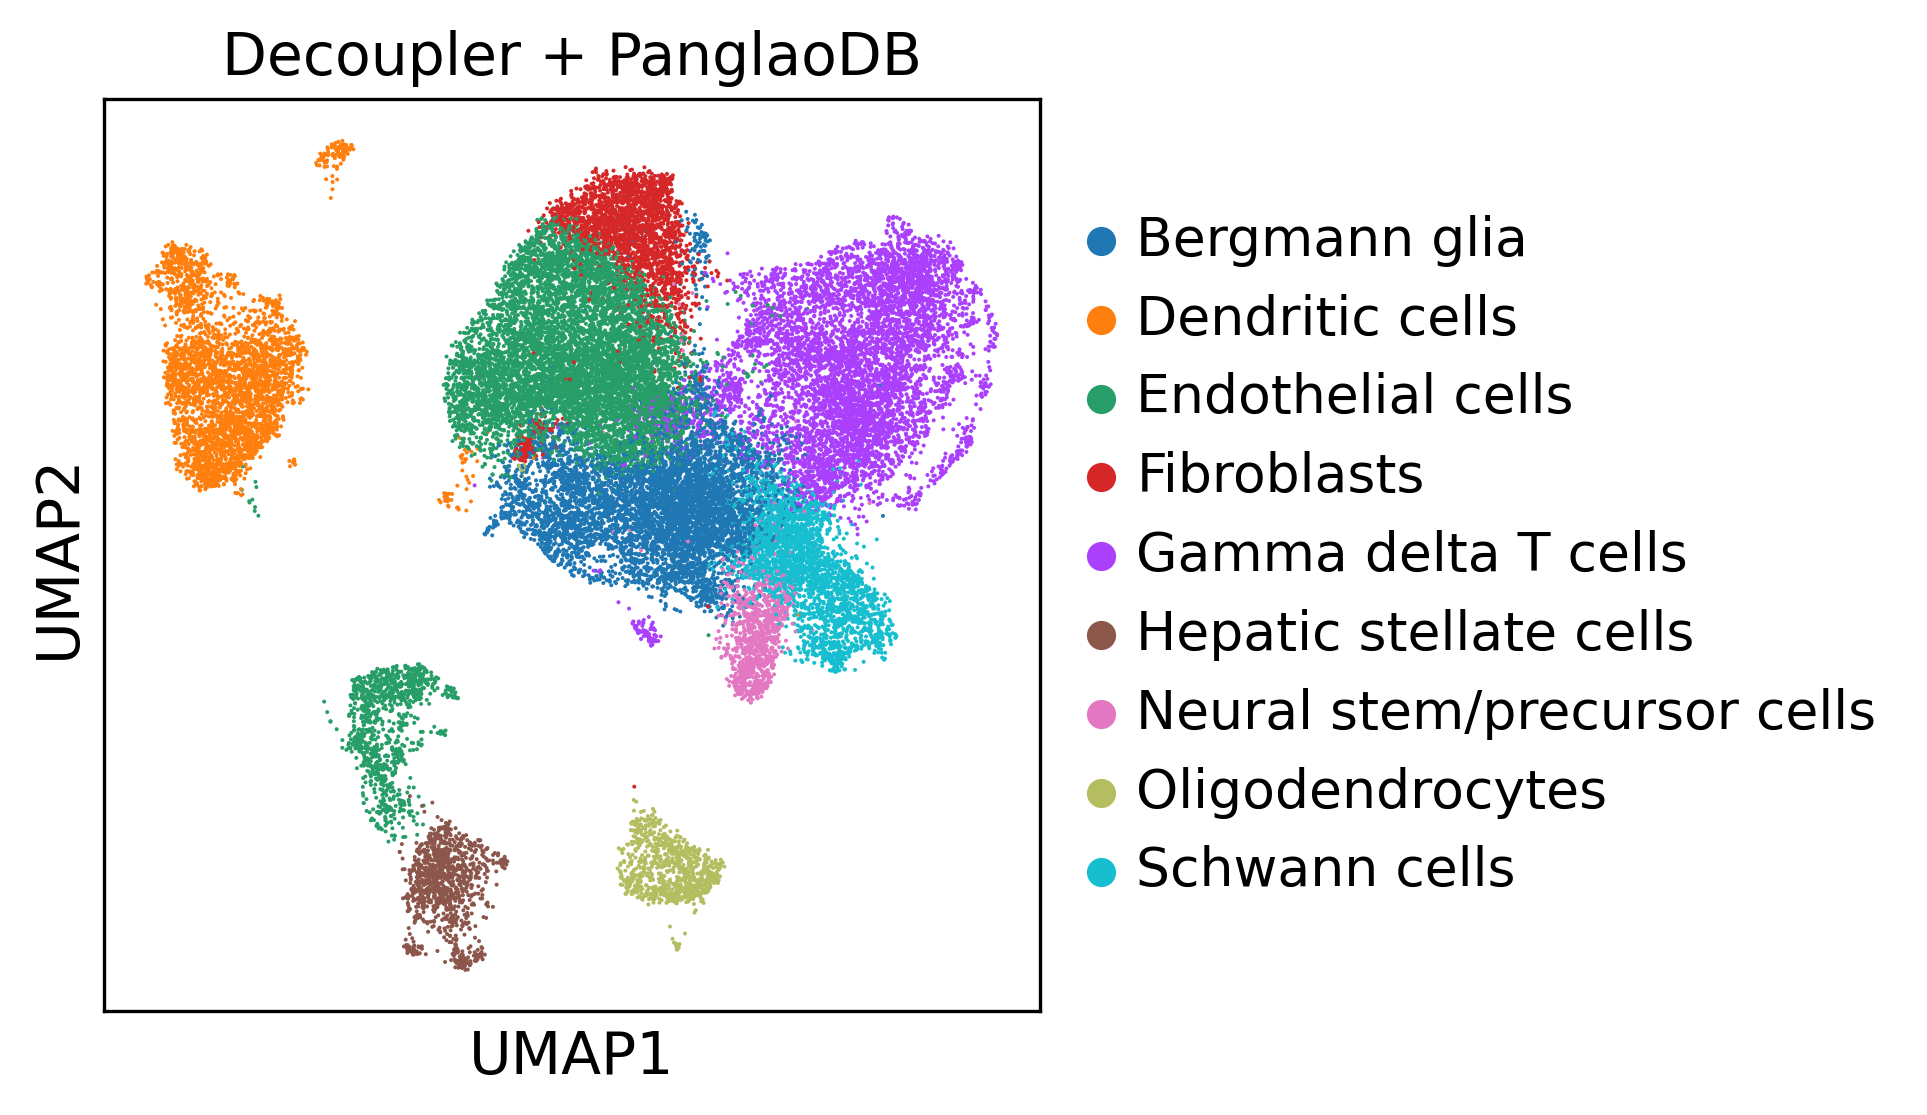

In [136]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type',title='Decoupler + PanglaoDB')

In [137]:
adata

AnnData object with n_obs × n_vars = 32763 × 2470
    obs: 'SampleID', 'GEO_RNA', 'Cohort', 'Type', 'Subtype', 'Diagnosis', 'Grade', 'Location', 'IDH1_Status', 'EGFR_Status', 'MGMT', 'CellCount', 'Sample', 'Sex', 'Age', 'Sorted', 'MET', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score', 'leiden', 'cell_type'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'SampleID_colors', 'doublet_info_colors', 'pca', 'neighbors', 'umap', 'log1p', 'hvg', 'leiden', 'majority_voting_colors', 'leiden_colors', 'cell_type_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X

In [138]:
adata.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Part1_P_GSE173278PMID35303420.h5ad")